In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dataprep.clean import clean_country
import dask.dataframe as dd

In [3]:
# original site has a tool to query the data you want and it make the dataset more
# closer to what we need, so it would require 


In [4]:
# the csv is huge so i use dask
csv_file_path = "/home/amir/big_storage/datasets/IHME-GDB-Risk-Deaths.csv"
dask_df= dd.read_csv(csv_file_path)


In [5]:
df_global = dask_df[dask_df.location=="Global"]
dask_df = dask_df[dask_df.location!="Global"]
dask_df = clean_country(dask_df, 'location', output_format='alpha-3')
dask_df.head()
 

  0%|          | 0/172 [00:00<?, ?it/s]

Country Cleaning Report:
	9196380 values cleaned (100.0%)
Result contains 9196380 (100.0%) values in the correct format and 0 null values (0.0%)


,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,Deaths,El Salvador,Female,35 to 39,Cardiovascular diseases,All risk factors,Number,2006,27.305953,32.514418,23.081097,SLV
1,Deaths,El Salvador,Both,35 to 39,Cardiovascular diseases,All risk factors,Number,2006,73.716938,89.396464,63.625658,SLV
2,Deaths,El Salvador,Male,35 to 39,Cardiovascular diseases,All risk factors,Rate,2006,28.985719,36.891028,23.719359,SLV
3,Deaths,El Salvador,Female,35 to 39,Cardiovascular diseases,All risk factors,Rate,2006,13.654947,16.259556,11.542215,SLV
4,Deaths,El Salvador,Both,35 to 39,Cardiovascular diseases,All risk factors,Rate,2006,20.471931,24.826292,17.669481,SLV


In [6]:
cause_list = [
    "Depressive disorders",
    "Cardiovascular diseases",
    "Chronic respiratory diseases",
    "Neurological disorders",
    "Tracheal, bronchus, and lung cancer",
    "Stomach cancer",
    "Pancreatic cancer",
    "Leukemia",
    "Esophageal cancer",
    "Larynx cancer",
    "Colon and rectum cancer",
    "Liver cancer",
    "Other non-communicable diseases",
]


In [198]:
df = dask_df[
    dask_df.cause.isin(cause_list)
    # (dask_df.cause=="All causes")
    & (dask_df.metric == "Rate")
    & (dask_df.sex == "Both")
    & (dask_df.year >= 2010)
    # & (dask_df.rei == "All risk factors")
    & (dask_df.rei == "Air pollution")
]
df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
27781,Deaths,Ethiopia,Both,85 plus,Other non-communicable diseases,Air pollution,Rate,2012,0.000000,0.000000,0.000000,ETH
28657,Deaths,Belgium,Both,25 to 29,Chronic respiratory diseases,Air pollution,Rate,2012,0.022587,0.033853,0.013638,BEL
28663,Deaths,Belgium,Both,30 to 34,Chronic respiratory diseases,Air pollution,Rate,2012,0.037161,0.056878,0.022765,BEL
28669,Deaths,Belgium,Both,35 to 39,Chronic respiratory diseases,Air pollution,Rate,2012,0.070377,0.104083,0.045132,BEL
28675,Deaths,Belgium,Both,40 to 44,Chronic respiratory diseases,Air pollution,Rate,2012,0.189128,0.267197,0.123217,BEL


In [199]:
# let see which country suffer the most from this disease in recent years
df.age.unique()

array(['85 plus', '25 to 29', '30 to 34', '35 to 39', '40 to 44',
       '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69',
       '70 to 74', '75 to 79', '80 to 84'], dtype=object)

In [200]:
total_by_country = df[(df.sex=="Both") & (df.year == 2017)].groupby(["location", "location_clean"]).agg(
    val_sum=("val", "sum"),
    val_mean=("val", "mean"),
    val_fisr=("val", "min"),
    val_max=("val", "max"),

).reset_index()

total_by_country.head()
# .sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

,location,location_clean,val_sum,val_mean,val_fisr,val_max
0,Afghanistan,AFG,10173.691086,260.863874,0.144592,2299.081096
1,Albania,ALB,3443.809665,88.302812,0.036182,1135.291591
2,Algeria,DZA,4427.828059,113.534053,0.035860,1892.843703
3,Argentina,ARG,1049.951235,26.921827,0.043376,241.701123
4,Armenia,ARM,4516.643019,115.811359,0.064922,1276.720792


In [201]:
world = df.groupby(['location',"location_clean", 'age', 'year']).agg(
    val_sum=("val", "sum"),
    val_mean=("val", "mean"),
    val_first=("val", "min"),
    val_max=("val", "max"),
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int')).reset_index()
world.head()

,location,location_clean,age,year,val_sum,val_mean,val_first,val_max
0,Afghanistan,AFG,25 to 29,2010,17.236644,5.745548,0.150468,15.351325
1,Pakistan,PAK,25 to 29,2012,10.977146,3.659049,0.132684,10.323202
2,Pakistan,PAK,25 to 29,2013,11.183041,3.727680,0.134844,10.523817
3,Pakistan,PAK,25 to 29,2014,11.309370,3.769790,0.136738,10.651012
4,Pakistan,PAK,25 to 29,2015,11.317433,3.772478,0.136471,10.670210


In [202]:
df[(df.location_clean=='IRN')]

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
188134,Deaths,Iran (Islamic Republic of),Both,25 to 29,Cardiovascular diseases,Air pollution,Rate,2011,4.158459,4.885259,3.433990,IRN
188140,Deaths,Iran (Islamic Republic of),Both,30 to 34,Cardiovascular diseases,Air pollution,Rate,2011,6.294470,7.570152,5.197750,IRN
188146,Deaths,Iran (Islamic Republic of),Both,35 to 39,Cardiovascular diseases,Air pollution,Rate,2011,9.031009,10.914375,7.423223,IRN
188152,Deaths,Iran (Islamic Republic of),Both,40 to 44,Cardiovascular diseases,Air pollution,Rate,2011,15.610173,18.937008,12.662106,IRN
188158,Deaths,Iran (Islamic Republic of),Both,45 to 49,Cardiovascular diseases,Air pollution,Rate,2011,28.116434,33.942506,22.970002,IRN
...,...,...,...,...,...,...,...,...,...,...,...,...
128360,Deaths,Iran (Islamic Republic of),Both,65 to 69,Chronic respiratory diseases,Air pollution,Rate,2013,19.286817,24.001275,14.616973,IRN
128366,Deaths,Iran (Islamic Republic of),Both,70 to 74,Chronic respiratory diseases,Air pollution,Rate,2013,34.054811,42.453769,25.412773,IRN
128372,Deaths,Iran (Islamic Republic of),Both,75 to 79,Chronic respiratory diseases,Air pollution,Rate,2013,69.701158,86.115843,53.157551,IRN
128378,Deaths,Iran (Islamic Republic of),Both,80 to 84,Chronic respiratory diseases,Air pollution,Rate,2013,120.027498,149.057336,89.597298,IRN


In [203]:
china = df[df.location=="China"].groupby(["location", "location_clean", "age"]).agg(
    val_sum=("val", "sum"),
    val_mean=("val", "mean"),
    val_first=("val", "min"),
    val_max=("val", "max"),
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int')).reset_index()
china.head(40)

,location,location_clean,age,val_sum,val_mean,val_first,val_max
0,China,CHN,25 to 29,42.478308,1.415944,0.112679,4.137341
1,China,CHN,30 to 34,79.238005,2.641267,0.231931,7.699838
2,China,CHN,35 to 39,135.269191,4.508973,0.418678,12.343705
3,China,CHN,40 to 44,258.560592,8.618686,0.931691,23.996185
4,China,CHN,45 to 49,435.028397,14.500947,1.725389,40.329065
5,China,CHN,50 to 54,695.544807,23.184827,3.950061,58.851724
6,China,CHN,55 to 59,1168.495702,38.949857,8.369452,93.436351
7,China,CHN,60 to 64,2091.307910,69.710264,19.819554,168.621468
8,China,CHN,65 to 69,3532.899597,117.763320,44.151035,267.342121
9,China,CHN,70 to 74,6518.397990,217.279933,77.042370,464.698299


In [204]:
# create lables for chart
x_axis_label = [i.replace(' to ', '-') for i in sorted(dask_df.age.unique(), key=lambda x: int(x.split(' ')[0]))]
print(x_axis_label)

['1-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 plus']


In [205]:
i = len(x_axis_label) -  len(china.val_mean.values)
print([0]* i)
chart_value = [0]* i + list(china.val_mean.values)

print(chart_value)

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1.4159435991968319, 2.6412668444598073, 4.508973027716887, 8.61868639576595, 14.500946574228434, 23.184826894557993, 38.949856726033545, 69.7102636626614, 117.76331989171922, 217.27993301236648, 367.6790883956447, 644.0132343921839, 839.2071285116084]


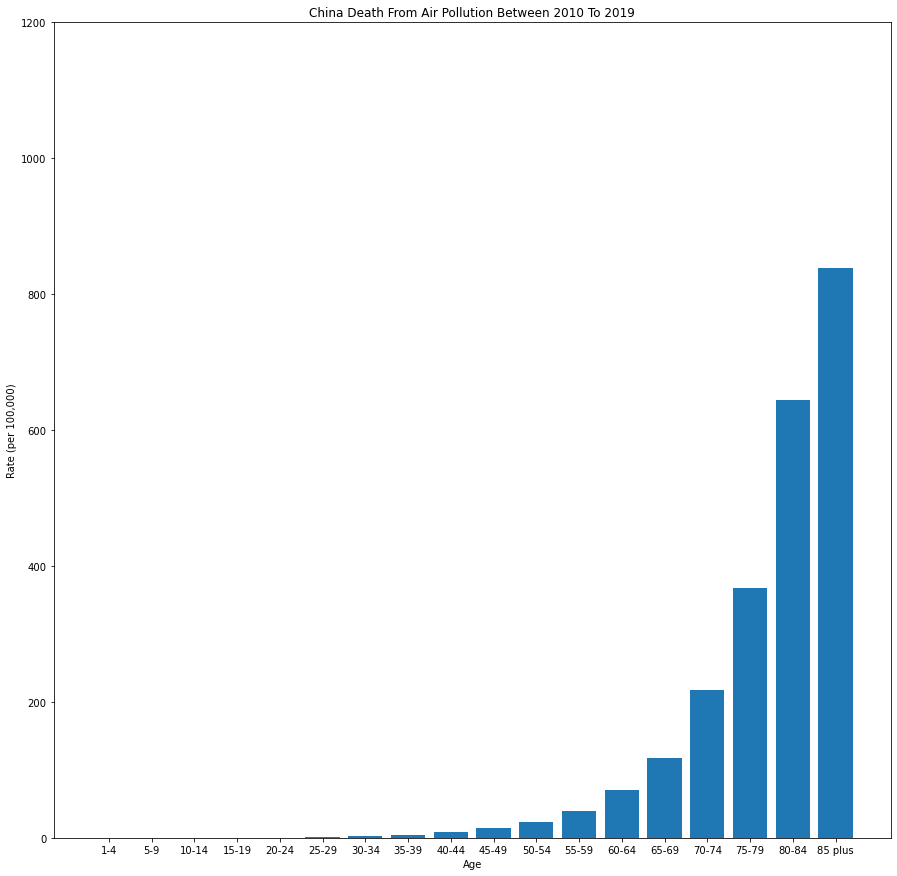

In [206]:
# plot for one country
fig, ax = plt.subplots(figsize=(15, 15))
ax.bar(x=x_axis_label, height=chart_value)
ax.set_title("China Death From Air Pollution Between 2010 To 2019")

ax.set_ylim((0, 1200))
ax.set_ylabel("Rate (per 100,000)")
ax.set_xlabel("Age")
plt.savefig("q4chiandeathair.png")
plt.show()

In [84]:
l = {"Afghanestan": "AFG", "Qatar": "QAT", "India": "IND","Iran": "IRN", "USA": "USA", "Findland": "FIN", "China": "CHN", }


In [15]:
fig_data = []
for name, code in l.items():

    country_states = (
        df[(df.location_clean == code)]
        .groupby(["location", "location_clean", "age"])
        .agg(
            val_sum=("val", "sum"),
            val_mean=("val", "mean"),
            val_first=("val", "min"),
            val_max=("val", "max"),
        )
        .sort_values(
            by="age", key=lambda x: x.str.split(" ", expand=True)[0].astype("int")
        )
        .reset_index()
    )
    fig_data.append(go.Bar(name=name, x=x_axis_label, y=country_states.val_mean))
# Change the bar mode
fig = go.Figure(data=fig_data)
fig.update_layout(
    barmode="group",
    xaxis_title="Country",
    yaxis_title="Risk Mean (2010-2015)",
    legend_title="Risk Factor",
    title="Countries Death Rate From Air Pollution Compare",
)
fig.write_html("q4countrydeathreate.html")
fig.show()


In [16]:
world[(world.location_clean=="AFG") & (world.year==2019)]

,location,location_clean,age,year,val_sum,val_mean,val_first,val_max
1243,Afghanistan,AFG,25 to 29,2019,13.060393,4.353464,0.143207,11.735029
3046,Afghanistan,AFG,30 to 34,2019,24.843246,8.281082,0.374192,22.688404
3589,Afghanistan,AFG,35 to 39,2019,47.487818,15.829273,0.772619,43.854914
6236,Afghanistan,AFG,40 to 44,2019,93.133067,31.044356,1.579558,86.813732
6521,Afghanistan,AFG,45 to 49,2019,165.923218,55.307739,3.453980,152.955104
8429,Afghanistan,AFG,50 to 54,2019,260.967860,86.989287,6.163721,236.482233
10772,Afghanistan,AFG,55 to 59,2019,388.427975,129.475992,9.203759,345.094993
11998,Afghanistan,AFG,60 to 64,2019,544.712911,181.570970,14.821043,470.307569
13901,Afghanistan,AFG,65 to 69,2019,752.809274,250.936425,19.918595,638.219049
14181,Afghanistan,AFG,70 to 74,2019,1073.847526,357.949175,27.218906,891.925766


In [17]:
world.val_max == world.val_max.max()

0        False
1        False
2        False
3        False
4        False
         ...  
20405    False
20406    False
20407    False
20408    False
20409    False
Name: val_max, Length: 20410, dtype: bool

In [18]:
# each country highest death rate of 

In [19]:
death_high_in_age = world.groupby("location_clean").apply(
    lambda x:  x[x.val_max==x.val_max.max()].drop("location_clean", axis=1)
).sort_values(by='val_max', ascending=False).reset_index().drop("level_1", axis=1)
death_high_in_age.head()

,location_clean,location,age,year,val_sum,val_mean,val_first,val_max
0,UZB,Uzbekistan,85 plus,2012,4796.843106,1598.947702,24.263834,4594.884698
1,NPL,Nepal,85 plus,2016,4707.972518,1569.324173,27.158033,3641.060516
2,MKD,North Macedonia,85 plus,2010,3855.777835,1285.259278,52.858867,3526.343683
3,MNG,Mongolia,85 plus,2010,3275.377881,1091.792627,102.946896,2902.135967
4,AZE,Azerbaijan,85 plus,2015,3051.218300,1017.072767,29.437158,2780.788557


In [20]:

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
    header=dict(values=list(['<b>Country<b>', "age", "max death"]),
        line_color='darkslategray',
        fill_color=headerColor,
        align=['left','center'],
        font=dict(color='white')),
    cells=dict(values=[death_high_in_age.location, death_high_in_age.age, death_high_in_age.val_max],
        line_color='darkslategray',
        # 2-D list of colors for alternating rows
        fill_color = [[rowOddColor,rowEvenColor]*death_high_in_age.shape[0]],
        align = ['left', 'center'],
        font = dict(color = 'darkslategray')
    ))
])
fig.update_layout(
    title="Age range With Highest Risk Duo To Air Pollution<br>sorted"
)
fig.write_html("q4agerange.html")
fig.show()
